<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# NOTE: get data from https://www.kaggle.com/danofer/sarcasm
## Too large for github/box

In [7]:
import requests
import zipfile
import io
import pandas as pd

url="https://www.kaggle.com/danofer/sarcasm/download"

r = requests.get(url)

r.headers
#remotezip = requests.get(url)
#remotezip.content
#root = zipfile.ZipFile(io.BytesIO(remotezip.content))
#for name in root.namelist():
    #print(name)
    #df = pd.read_csv(root.open(name)) 

{'Date': 'Thu, 11 Jun 2020 23:47:41 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Cache-Control': 'no-cache, no-store', 'Pragma': 'no-cache', 'Content-Encoding': 'gzip', 'Set-Cookie': 'CSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL_rTYY1B936tBebdaXMk_CJyUQmnx3b4-g1fi_06RlhK5irWHy2JthgLPBQlA80V4v1gi7Y1ZdyX7v5Z0sX20y0tohAzgCckaHaALK8rEsUEDLuejr8YSymYi4SxzBSKyU; path=/; secure; samesite=lax; httponly, XSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL-RY85SOTR1A5Lr6XD2KtcL4zy171lUS5bkRE4NJUTV65LGStQgl3D30hgeVG5RBq6-1xQ84f0ejomD_n6ZDPEmMWj5NqFc_ma7laccj2FRTFXbXblncmBYLoM_qDJC88c; path=/; secure; samesite=lax, CLIENT-TOKEN=eyJhbGciOiJub25lIiwidHlwIjoiSldUIn0.eyJpc3MiOiJrYWdnbGUiLCJhdWQiOiJjbGllbnQiLCJzdWIiOm51bGwsIm5idCI6IjIwMjAtMDYtMTFUMjM6NDc6NDEuOTI3NzgxOVoiLCJpYXQiOiIyMDIwLTA2LTExVDIzOjQ3OjQxLjkyNzc4MTlaIiwianRpIjoiZjllZTk4MjItMDNjYS00ZTg2LThkYmMtZTVjZDBiMTZhOTM4IiwiZXhwIjoiMjAyMC0wNy0xMVQyMzo0Nzo0MS45Mjc3ODE5WiIsImFub24iOnRydWUsImZmIjpbIkZsZXhpYmxlR3B1IiwiS2VybmVsc0ludGVybmV0IiwiRGF0YUV4cGxvcmVyVjIiLCJ

In [2]:
https://www.kaggle.com/danofer/sarcasm/download/
%cd /notebooks
datadir = "data/"

/notebooks


In [3]:
!ls -ls data/*sarcasm*

261960 -rw-rw-r-- 1 501 80 255268960 Dec 18 05:30 data/train-balanced-sarcasm.csv


In [4]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
train_df = pd.read_csv(datadir + 'train-balanced-sarcasm.csv')

In [6]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [8]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [9]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [10]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [11]:
train_texts.shape, valid_texts.shape, y_train.shape, y_valid.shape

((758079,), (252694,), (758079,), (252694,))

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

In [12]:
!pip install wordcloud --user

In [13]:
!pip install eli5 --user

## Part 1. Exploratory data analysis

In [14]:
import eli5
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS

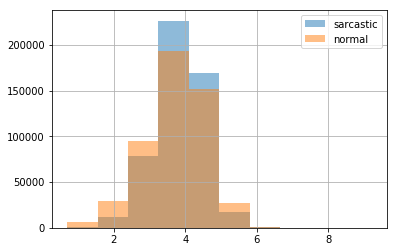

In [15]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [16]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

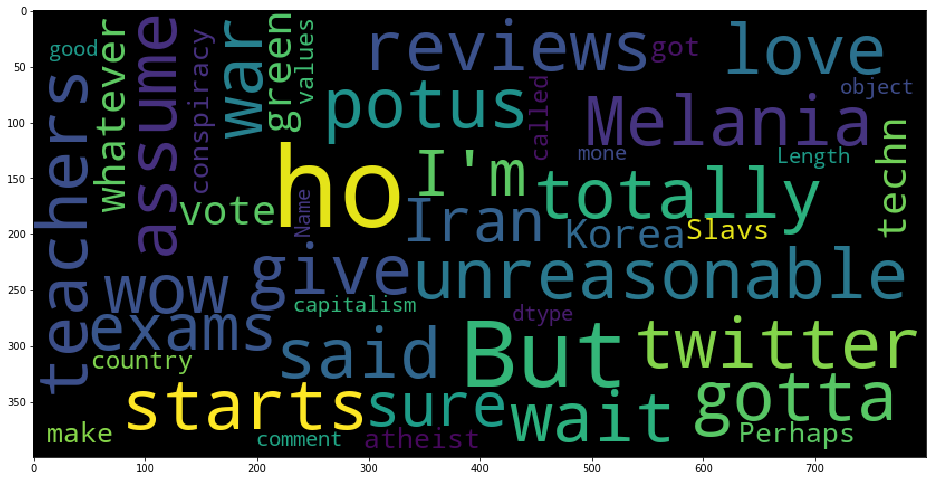

In [17]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

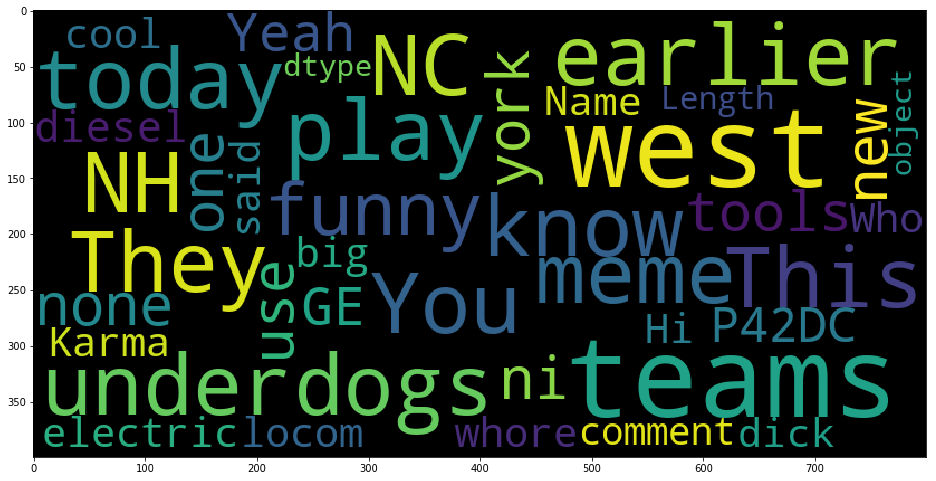

In [18]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [19]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [20]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [21]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [22]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [23]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


## Part 2. Training a model

In [24]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=2, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

CPU times: user 0 ns, sys: 703 µs, total: 703 µs
Wall time: 728 µs


In [25]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 56.6 s, sys: 1.86 s, total: 58.4 s
Wall time: 1min 29s


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   31.2s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [26]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 11 s, sys: 153 ms, total: 11.2 s
Wall time: 11.1 s


In [27]:
init_score = accuracy_score(y_valid, valid_pred)
init_score

0.7208639698607803

## Part 3. Explaining the model

In [28]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.show()
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

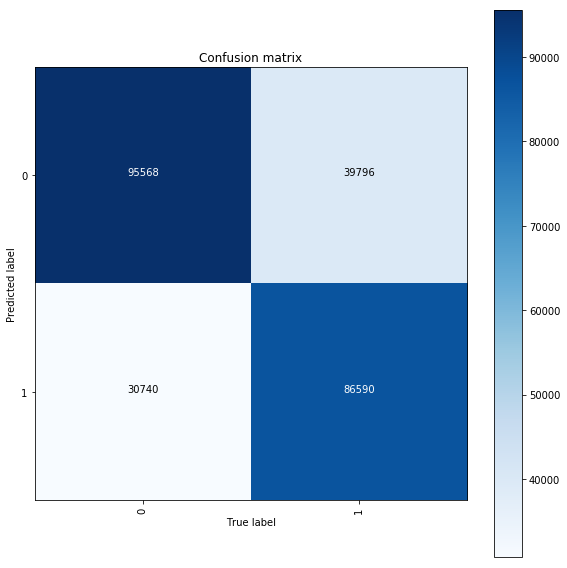

In [29]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [30]:
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.672,yes because
+8.277,clearly
+7.998,obviously
+7.373,totally
+7.369,yeah because
+5.992,because
+5.923,how dare
+5.886,right because
+5.602,but thought
+5.063,gee


## Part 4. Improving the model

In [31]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [32]:
%%time
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

CPU times: user 99 µs, sys: 0 ns, total: 99 µs
Wall time: 118 µs


In [33]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)
X_train_texts.shape, X_valid_texts.shape

CPU times: user 57.2 s, sys: 2.02 s, total: 59.2 s
Wall time: 1min 1s


((758079, 50000), (252694, 50000))

In [34]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)
X_train_subreddits.shape, X_valid_subreddits.shape

CPU times: user 6.75 s, sys: 64.1 ms, total: 6.81 s
Wall time: 7.51 s


((758079, 13255), (252694, 13255))

In [35]:
%%time
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])
X_train.shape, X_valid.shape

CPU times: user 1.04 s, sys: 1.09 s, total: 2.12 s
Wall time: 2.34 s


((758079, 63255), (252694, 63255))

In [36]:
%%time
logit.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 708 ms, sys: 497 ms, total: 1.21 s
Wall time: 1min 33s


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:  1.5min finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=2, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [37]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 310 ms, sys: 51.4 ms, total: 361 ms
Wall time: 415 ms


In [38]:
improved_score = accuracy_score(y_valid, valid_pred)
print(improved_score, " improvement =", improved_score - init_score)

0.7237844982468915  improvement = 0.002920528386111232


## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions